In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
device

device(type='cuda', index=0)

In [2]:
dataset_path = "/kaggle/input/vn-celeb-face/VN-celeb"
work_dir = os.getcwd()
work_dir

'/kaggle/working'

In [3]:
train_dir = os.path.join(work_dir,'train')      
test_dir = os.path.join(work_dir,'test')        
os.makedirs(train_dir, exist_ok=True)  
os.makedirs(test_dir, exist_ok=True)  

In [4]:
train_ratio=0.8
test_ratio=0.2
dir_list=os.listdir(os.path.join(work_dir ,dataset_path))
print('The Number of Classes in the Dataset is:{}'.format(len(dir_list)))

The Number of Classes in the Dataset is:1020


In [5]:
from shutil import copyfile
import numpy as np

dir_list = os.listdir(dataset_path)

for folder in dir_list:
    data_dir = os.listdir(os.path.join(dataset_path,folder))
    np.random.shuffle(data_dir)
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, folder), exist_ok=True)
    
    if len(data_dir) > 20:
        train_data = data_dir[:int(len(data_dir)*train_ratio+1)]
        test_data = data_dir[-int(len(data_dir)*test_ratio):]
        
        for image in train_data:
            copyfile(os.path.join(dataset_path,folder,image), os.path.join(train_dir,folder,image))
        
        for image in test_data:
            copyfile(os.path.join(dataset_path,folder,image), os.path.join(test_dir,folder,image))
    else:
        test_data = data_dir[-int(len(data_dir)*0.1):]
        for image in data_dir:
            copyfile(os.path.join(dataset_path,folder,image), os.path.join(train_dir,folder,image))

        for image in test_data:
            copyfile(os.path.join(dataset_path,folder,image), os.path.join(test_dir,folder,image))
    

In [6]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/kaggle/input/vn-celeb-face/VN-celeb'
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
test_dataset = datasets.ImageFolder(test_dir, transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 19959
Test dataset size: 4952
Class names: ['1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2'

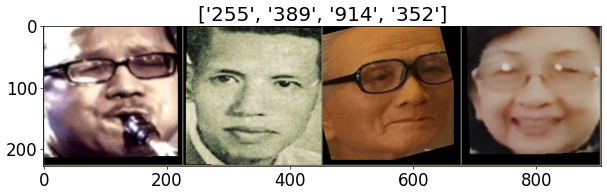

In [7]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [8]:
class FaceIdentification(nn.Module):
    def __init__(self, num_classes):
        super(FaceIdentification, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.features(x)
        features = features.view(features.size(0), -1)
        out = self.fc(features)
        return out

    def extract_features(self, x):
        features = self.features(x)
        features = features.view(features.size(0), -1)
        return features

In [9]:
model = FaceIdentification(1020)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,  # Standard Adam learning rate
    betas=(0.9, 0.999),  # Default beta parameters
    weight_decay=0.01  # L2 regularization to prevent overfitting
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',  # Reduce LR when metric stops decreasing
    factor=0.1,  # Multiply LR by this factor when plateauing
    patience=3,   # Number of epochs to wait before reducing LR
    verbose=True,
    min_lr=1e-6  # Minimum LR threshold
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

In [11]:
from tqdm import tqdm

num_epochs = 30
start_time = time.time()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# early stopping params
best_acc = 0.0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    """ Training Phase """
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    progress = tqdm(train_dataloader, desc='Training')
    
    for inputs, labels in progress:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad(set_to_none=True)

        # mixed precision training
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        progress.set_postfix({'batch_loss': loss.item()})

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = (running_corrects / len(train_dataset)) * 100.
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.cpu())

    """ Test Phase """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        progress = tqdm(test_dataloader, desc='Testing')
        for inputs, labels in progress:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            progress.set_postfix({'batch_loss': loss.item()})

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = (running_corrects / len(test_dataset)) * 100.
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc.cpu())

    print(f'Train Loss: {train_losses[-1]:.4f} Acc: {train_accuracies[-1]:.2f}%')
    print(f'Test Loss: {test_losses[-1]:.4f} Acc: {test_accuracies[-1]:.2f}%')
    print(f'Time: {(time.time() - start_time)/60:.2f} min')

    # lr scheduling
    scheduler.step(epoch_loss)

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_loss,
            'test_acc': epoch_acc,
        }, 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after epoch {epoch+1}')
            break

print(f'\nBest test accuracy: {best_acc:.2f}%')


Epoch 1/30
----------


Training:   0%|          | 0/1248 [00:00<?, ?it/s]/tmp/ipykernel_23/1534928972.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision training
Testing: 100%|██████████| 310/310 [00:09<00:00, 33.30it/s, batch_loss=6.28]


Train Loss: 6.6084 Acc: 0.99%
Test Loss: 6.0264 Acc: 2.50%
Time: 1.29 min

Epoch 2/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 32.68it/s, batch_loss=4.86]


Train Loss: 5.2672 Acc: 5.41%
Test Loss: 4.7160 Acc: 10.54%
Time: 2.57 min

Epoch 3/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 32.05it/s, batch_loss=2.29]


Train Loss: 4.2294 Acc: 15.00%
Test Loss: 3.7045 Acc: 21.34%
Time: 3.85 min

Epoch 4/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 33.90it/s, batch_loss=4.77]


Train Loss: 3.4226 Acc: 26.08%
Test Loss: 3.0317 Acc: 33.00%
Time: 5.10 min

Epoch 5/30
----------


Testing: 100%|██████████| 310/310 [00:08<00:00, 34.77it/s, batch_loss=2.23]


Train Loss: 2.7609 Acc: 37.95%
Test Loss: 2.4960 Acc: 40.73%
Time: 6.36 min

Epoch 6/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 32.67it/s, batch_loss=2.61] 


Train Loss: 2.2335 Acc: 48.42%
Test Loss: 2.1102 Acc: 49.72%
Time: 7.61 min

Epoch 7/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 34.35it/s, batch_loss=1.89] 


Train Loss: 1.8084 Acc: 57.65%
Test Loss: 1.6060 Acc: 60.95%
Time: 8.87 min

Epoch 8/30
----------


Testing: 100%|██████████| 310/310 [00:08<00:00, 34.72it/s, batch_loss=1.92] 


Train Loss: 1.4743 Acc: 64.59%
Test Loss: 1.4077 Acc: 65.55%
Time: 10.12 min

Epoch 9/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 34.29it/s, batch_loss=1]    


Train Loss: 1.2370 Acc: 69.86%
Test Loss: 1.2412 Acc: 70.23%
Time: 11.37 min

Epoch 10/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 33.57it/s, batch_loss=1.24] 


Train Loss: 1.0460 Acc: 73.86%
Test Loss: 1.1648 Acc: 72.42%
Time: 12.63 min

Epoch 11/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 34.22it/s, batch_loss=2.65] 


Train Loss: 0.8842 Acc: 78.15%
Test Loss: 1.0363 Acc: 75.85%
Time: 13.89 min

Epoch 12/30
----------


Testing: 100%|██████████| 310/310 [00:08<00:00, 34.46it/s, batch_loss=1.08] 


Train Loss: 0.7584 Acc: 80.34%
Test Loss: 0.9591 Acc: 77.89%
Time: 15.15 min

Epoch 13/30
----------


Testing: 100%|██████████| 310/310 [00:08<00:00, 34.82it/s, batch_loss=0.607] 


Train Loss: 0.6550 Acc: 82.76%
Test Loss: 0.9237 Acc: 78.27%
Time: 16.39 min

Epoch 14/30
----------


Testing: 100%|██████████| 310/310 [00:08<00:00, 34.57it/s, batch_loss=0.876] 


Train Loss: 0.5781 Acc: 84.95%
Test Loss: 0.9051 Acc: 79.75%
Time: 17.64 min

Epoch 15/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 33.07it/s, batch_loss=0.182] 


Train Loss: 0.4951 Acc: 86.79%
Test Loss: 0.8247 Acc: 81.66%
Time: 18.91 min

Epoch 16/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 34.15it/s, batch_loss=0.317] 


Train Loss: 0.4479 Acc: 88.00%
Test Loss: 0.8547 Acc: 81.10%
Time: 20.18 min

Epoch 17/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 33.76it/s, batch_loss=0.0457]


Train Loss: 0.3863 Acc: 89.35%
Test Loss: 0.8347 Acc: 82.21%
Time: 21.43 min

Epoch 18/30
----------


Testing: 100%|██████████| 310/310 [00:08<00:00, 34.54it/s, batch_loss=0.0544]


Train Loss: 0.3486 Acc: 90.50%
Test Loss: 0.8245 Acc: 82.86%
Time: 22.65 min

Epoch 19/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 34.17it/s, batch_loss=0.573] 


Train Loss: 0.3173 Acc: 91.26%
Test Loss: 0.8438 Acc: 82.69%
Time: 23.90 min

Epoch 20/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 34.31it/s, batch_loss=0.151] 


Train Loss: 0.2934 Acc: 91.99%
Test Loss: 0.8398 Acc: 82.63%
Time: 25.14 min

Epoch 21/30
----------


Testing: 100%|██████████| 310/310 [00:08<00:00, 34.53it/s, batch_loss=0.735]  


Train Loss: 0.2622 Acc: 92.60%
Test Loss: 0.8094 Acc: 84.17%
Time: 26.40 min

Epoch 22/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 34.32it/s, batch_loss=0.488] 


Train Loss: 0.2470 Acc: 93.15%
Test Loss: 0.8138 Acc: 84.37%
Time: 27.64 min

Epoch 23/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 33.41it/s, batch_loss=1.34]  


Train Loss: 0.2306 Acc: 93.41%
Test Loss: 0.7807 Acc: 84.63%
Time: 28.90 min

Epoch 24/30
----------


Testing: 100%|██████████| 310/310 [00:08<00:00, 34.86it/s, batch_loss=0.0219]


Train Loss: 0.2180 Acc: 93.73%
Test Loss: 0.7789 Acc: 86.11%
Time: 30.14 min

Epoch 25/30
----------


Testing: 100%|██████████| 310/310 [00:08<00:00, 34.89it/s, batch_loss=0.0957]


Train Loss: 0.2024 Acc: 94.27%
Test Loss: 0.7910 Acc: 85.20%
Time: 31.39 min

Epoch 26/30
----------


Testing: 100%|██████████| 310/310 [00:08<00:00, 34.72it/s, batch_loss=0.473]  


Train Loss: 0.1883 Acc: 94.57%
Test Loss: 0.8015 Acc: 84.87%
Time: 32.62 min

Epoch 27/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 33.26it/s, batch_loss=0.0141] 


Train Loss: 0.1709 Acc: 95.09%
Test Loss: 0.8387 Acc: 85.18%
Time: 33.86 min

Epoch 28/30
----------


Testing: 100%|██████████| 310/310 [00:08<00:00, 34.90it/s, batch_loss=0.358] 


Train Loss: 0.1650 Acc: 95.19%
Test Loss: 0.8860 Acc: 84.35%
Time: 35.11 min

Epoch 29/30
----------


Testing: 100%|██████████| 310/310 [00:08<00:00, 35.37it/s, batch_loss=0.51]   


Train Loss: 0.0648 Acc: 98.28%
Test Loss: 0.6440 Acc: 88.63%
Time: 36.34 min

Epoch 30/30
----------


Testing: 100%|██████████| 310/310 [00:09<00:00, 33.57it/s, batch_loss=0.467]  


Train Loss: 0.0361 Acc: 99.06%
Test Loss: 0.6302 Acc: 89.03%
Time: 37.58 min

Best test accuracy: 89.03%


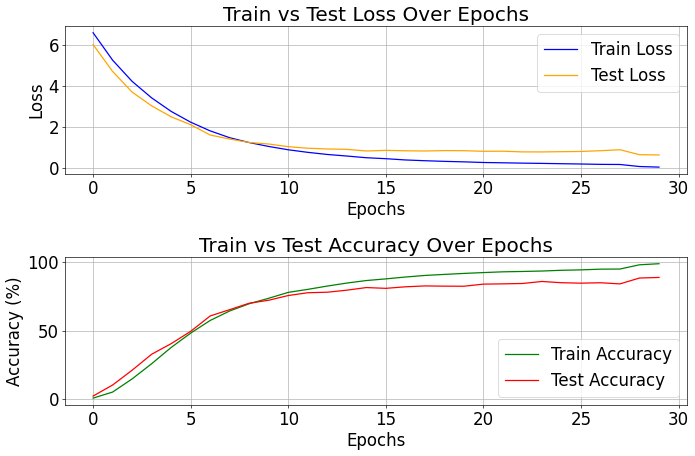

In [12]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss', color='blue')
plt.plot(range(num_epochs), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss Over Epochs')
plt.legend()
plt.grid()

# Plot the training and testing accuracy
plt.subplot(2, 1, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(num_epochs), test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [18]:
save_path = os.path.join(work_dir,'best_model2.pth')
torch.save(model.state_dict(), save_path)

[Prediction Result Examples]


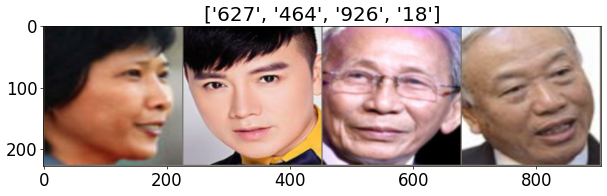

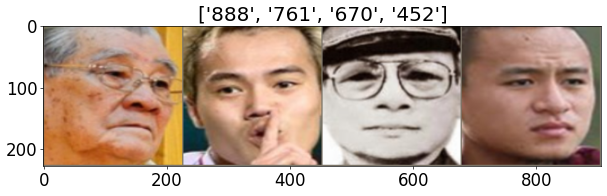

[Test #1] Loss: 0.6302 Acc: 89.0347% Time: 10.1437s


In [19]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(1, epoch_loss, epoch_acc, time.time() - start_time))

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9107
Recall: 0.8903
F1 Score: 0.8903


In [15]:
from PIL import Image
def predict_and_plot(image_path, model, class_names, device):
    model.eval()

    image = Image.open(image_path).convert('RGB')
    input_tensor = transforms_test(image).unsqueeze(0)
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_idx = torch.max(output, 1)

    predicted_label = class_names[predicted_idx.item()]

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_label}', fontsize=16)
    plt.axis('off')
    plt.show()

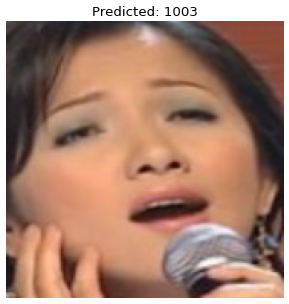

In [16]:
image_path = '/kaggle/input/vn-celeb-face/VN-celeb/1003/11.png'
predict_and_plot(image_path, model, class_names, device)

# Threshold

In [25]:
from collections import defaultdict
import random

class PairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, n_pairs=10000):
        self.dataset = dataset
        self.n_pairs = n_pairs
        self.labels = dataset.targets
        self.data_indices = defaultdict(list)
        
        for idx, label in enumerate(self.labels):
            self.data_indices[label].append(idx)
            
        self.valid_labels = [
            label for label in self.data_indices.keys() 
            if len(self.data_indices[label]) >= 2
        ]
        
        if not self.valid_labels:
            raise ValueError("No classes with at least 2 images found!")
    
    def __len__(self):
        return self.n_pairs
    
    def __getitem__(self, idx):
        while True:
            try:
                is_same = random.random() > 0.5
                
                if is_same:
                    label = random.choice(self.valid_labels)
                    if len(self.data_indices[label]) >= 2:
                        idx1, idx2 = random.sample(self.data_indices[label], 2)
                    else:
                        continue
                else:
                    if len(self.valid_labels) >= 2:
                        label1, label2 = random.sample(self.valid_labels, 2)
                        idx1 = random.choice(self.data_indices[label1])
                        idx2 = random.choice(self.data_indices[label2])
                    else:
                        continue
                
                img1, _ = self.dataset[idx1]
                img2, _ = self.dataset[idx2]
                
                return img1, img2, torch.tensor(1.0 if is_same else 0.0)
            
            except ValueError:
                continue

train_pairs = PairDataset(train_dataset, n_pairs=5000)
test_pairs = PairDataset(test_dataset, n_pairs=1000)

pair_train_loader = torch.utils.data.DataLoader(
    train_pairs, 
    batch_size=32, 
    shuffle=True, 
    num_workers=2
)
pair_test_loader = torch.utils.data.DataLoader(
    test_pairs, 
    batch_size=32, 
    shuffle=False, 
    num_workers=2
)

# Print some statistics
print(f"Number of valid classes in train: {len(train_pairs.valid_labels)}")
print(f"Number of valid classes in test: {len(test_pairs.valid_labels)}")

Number of valid classes in train: 1020
Number of valid classes in test: 735


100%|██████████| 32/32 [00:03<00:00,  8.13it/s]


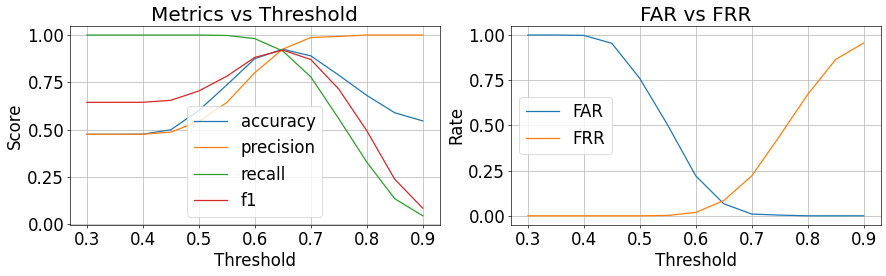

In [30]:
import random
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
def evaluate_thresholds(model, dataloader, device, thresholds=np.arange(0.3, 0.9, 0.05)):
    model.eval()
    similarities = []
    labels = []
    
    with torch.no_grad():
        for img1, img2, target in tqdm(dataloader):
            img1, img2 = img1.to(device), img2.to(device)
            
            emb1 = model.extract_features(img1)
            emb2 = model.extract_features(img2)
            
            sim = F.cosine_similarity(emb1, emb2)
            
            similarities.extend(sim.cpu().numpy())
            labels.extend(target.cpu().numpy())
    
    similarities = np.array(similarities)
    labels = np.array(labels)
    
    results = {}
    for threshold in thresholds:
        predictions = (similarities >= threshold).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        far = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Accept Rate
        frr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Reject Rate
        
        results[threshold] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'far': far,
            'frr': frr
        }
    
    return results

results = evaluate_thresholds(model, pair_test_loader, device)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.plot(results.keys(), [r[metric] for r in results.values()], label=metric)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True)

# far + frr
plt.subplot(1, 2, 2)
plt.plot(results.keys(), [r['far'] for r in results.values()], label='FAR')
plt.plot(results.keys(), [r['frr'] for r in results.values()], label='FRR')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('FAR vs FRR')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()